In [1]:
import torch 
import torch.nn as nn
from torch.autograd import grad
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn  as sns
np.random.seed(int(time.time()))
torch.manual_seed(int(time.time()))
device = torch.device("cpu")
print(torch.__version__)
print(torch.cuda.is_available())

1.11.0+cu113
False


In [2]:

class GP_1d(nn.Module):
    def __init__(self,
                nugget_size = 1e-6,
                lengthscale=0.2,
                noise_level = 0.05,
                sigma = 1,
                Mb = 4,
                 Mf = 10,
                device = device,
                 exact_func=None,
                 exact_rhs = None,
                 exact_b = None,
                 partial = False):

        super(GP_1d, self).__init__()

        self.device = device
        self.nugget_size = nugget_size
        self.Mf = Mf
        self.Mb = Mb
        self.lengthscale = nn.Parameter(torch.tensor([lengthscale],dtype=torch.float64), requires_grad=True)
        
        self.sigma = nn.Parameter(torch.tensor([sigma],dtype=torch.float64), requires_grad=True)
        self.sig_u = nn.Parameter(torch.randn(1,dtype=torch.float64), requires_grad=True)
        self.sig_f = nn.Parameter(torch.randn(1,dtype=torch.float64), requires_grad=True)
        
        
        self.noise_level = noise_level
        
        if exact_func == None:
             def exact_func(x):
                return -10/(2**2)*torch.sin(2*x)
             self.exact_func = exact_func
        else:
            self.exact_func = exact_func
            def exact_rhs(x):
                u = self.exact_func(x)
                temp = grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
                return grad(temp,x,grad_outputs=torch.ones_like(temp),create_graph=False)[0]
            self.exact_rhs = exact_rhs

        if exact_rhs == None:
            def exact_rhs(x):
                return 10*torch.sin(2*x)
            self.exact_rhs = exact_rhs
        if exact_b == None:
            def exact_b(x):
                return 0*x
            self.exact_b = exact_b


        # self.Xs = torch.rand(self.Mu,dtype = torch.float64,device = self.device,requires_grad=True).view(-1,1)*2-1
        # self.Xf = torch.rand(self.Mf,dtype = torch.float64,device = self.device,requires_grad=True).view(-1,1)*2-1
        Xf = np.random.uniform(-1,1,self.Mf).reshape(-1,1)
        self.Xf = torch.tensor(Xf,dtype=torch.float64,device=self.device,requires_grad=True)
        self.Xb = torch.tensor([-1,1],dtype = torch.float64,device=self.device,requires_grad=True).view(-1,1)
        Xb = np.random.uniform(-1,1,self.Mb-2).reshape(-1,1)
        Xbb = torch.tensor([-1,1],dtype=torch.float64,requires_grad=True).view(-1,1)
        self.Xb = torch.tensor(Xb,dtype = torch.float64,device=self.device,requires_grad=True).view(-1,1)
        self.Xb = torch.cat((self.Xb,Xbb),dim=0)
        self.Mb = self.Xb.shape[0]
        if partial ==True:
            left = np.random.uniform(-1,-0.2,int(0.5*self.Mf)).reshape(-1,1)
            right = np.random.uniform(0.5,1.0,int(0.5*self.Mf)).reshape(-1,1)
            self.Xf = torch.tensor(np.concatenate((left,right),axis=0),dtype = torch.float64,device = self.device,requires_grad=True).view(-1,1)
        self.Mf = self.Xf.shape[0]
        self.Yb = self.exact_func(self.Xb).detach()#+self.noise_level*torch.randn_like(self.Yb)*self.Yb
        self.Yb = self.Yb+self.noise_level*torch.randn_like(self.Yb)*self.Yb
        self.Yf = self.exact_rhs(self.Xf).detach()#+self.noise_level*torch.randn_like(self.Yf)*self.Yf 
        self.Yf = self.Yf+self.noise_level*torch.randn_like(self.Yf)*self.Yf 
        self.Y = torch.cat((self.Yb,self.Yf),dim=0).detach()
        self.nugget = 1e-6*torch.eye(self.Mb+self.Mf,dtype = torch.float64,device = self.device)

    def K(self, x, y):
        # Covariance function
        return (self.sigma**2)*torch.exp(-0.5*((self.lengthscale**(-2))*(x-y)**2))

    def K11(self,x ,y):
        xcombo = x.repeat(1,y.shape[1])
        ycombo = y.repeat(x.shape[0],1)
        
        return self.K(xcombo,ycombo)
    def K21(self, x, y):
        
        xcombo = x.repeat(1,y.shape[1])
        ycombo = y.repeat(x.shape[0],1)
        K = self.K(xcombo,ycombo)
        # K_x = grad(K,xcombo, grad_outputs = torch.ones_like(K),create_graph = True)[0]
        K_x = grad(K.sum(),xcombo,create_graph = True)[0]

        K_x1 = K_x#[:,0:1]
        # K_x2 = K_x[:,:,1]
        # K_x1x1 = grad(K_x1,xcombo,grad_outputs=torch.ones_like(K_x1),create_graph=True)[0]#[:,0:1]
        K_x1x1 = grad(K_x1.sum(),xcombo,create_graph=True)[0]#[:,0:1]
        # K_x2x2 = grad(K_x2,xcombo,grad_outputs=torch.ones_like(K_x2),create_graph=True)[0][:,:,1]
        # K_xx = (K_x1x1+K_x2x2)
        return K_x1x1

    
    def K12(self, x, y):
        
        xcombo = x.repeat(1,y.shape[1])
        ycombo = y.repeat(x.shape[0],1)
        K = self.K(xcombo,ycombo)
        # K_y = grad(K,ycombo, grad_outputs = torch.ones_like(K),create_graph = True)[0]
        K_y = grad(K.sum(),ycombo,create_graph = True)[0]
        # print(K_y.shape)

        K_y1 = K_y#[:,0:1]
        # print(K_y1.shape)
        # K_y2 = K_y[:,:,1]
        # K_y1y1 = grad(K_y1,ycombo,grad_outputs=torch.ones_like(K_y1),create_graph=True)[0]#[:,0:1]
        K_y1y1 = grad(K_y1.sum(),ycombo,create_graph=True)[0]#[:,0:1]
        # print(K_y1y1.shape)
        
        # K_y2y2 = grad(K_y2,ycombo,grad_outputs=torch.ones_like(K_y2),create_graph=True)[0][:,:,1]
        # K_yy = (K_y1y1+K_y2y2)
        # print(K_y1y1.shape)

        return K_y1y1

    
    def K22(self, x, y):
        xcombo = x.repeat(1,y.shape[1])
        ycombo = y.repeat(x.shape[0],1)
        K = self.K(xcombo,ycombo)
        # K_y = grad(K,ycombo, grad_outputs = torch.ones_like(K),create_graph = True)[0]
        K_y = grad(K.sum(),ycombo,create_graph = True)[0]

        K_y1 = K_y#[:,0:1]
        # K_y2 = K_y[:,:,1]
        # K_y1y1 = grad(K_y1,ycombo,grad_outputs=torch.ones_like(K_y1),create_graph=True)[0]#[:,0:1]
        K_y1y1 = grad(K_y1.sum(),ycombo,create_graph=True)[0]#[:,0:1]
        # K_y2y2 = grad(K_y2,ycombo,grad_outputs=torch.ones_like(K_y2),create_graph=True)[0][:,:,1]
        K_yy = K_y1y1#+K_y2y2

        # Kyyx = grad(K_yy,xcombo,grad_outputs=torch.ones_like(K_yy),create_graph=True)[0]
        Kyyx = grad(K_yy.sum(),xcombo,create_graph=True)[0]
        Kyyx1=Kyyx#[:,0:1]
        # Kyyx2=Kyyx[:,:,1]

        # Kyyx1x1 = grad(Kyyx1,xcombo,grad_outputs=torch.ones_like(Kyyx1),create_graph=True)[0]#[:,0:1]
        Kyyx1x1 = grad(Kyyx1.sum(),xcombo,create_graph=True)[0]#[:,0:1]
        # Kyyx2x2 = grad(Kyyx2,xcombo,grad_outputs=torch.ones_like(Kyyx2),create_graph=True)[0][:,:,1]

        Kyyxx = Kyyx1x1#+Kyyx2x2
        return Kyyxx

    def make_Theta(self):
        
        If = (self.sig_f**2)*torch.eye(self.Mf,dtype = torch.float64,device = self.device)
        Ib = (self.sig_u**2)*torch.eye(self.Mb,dtype = torch.float64,device = self.device)
        
        K11 = self.K11(self.Xb,self.Xb.swapaxes(0,1))
        K12 = self.K12(self.Xb,self.Xf.swapaxes(0,1))
        K21 = self.K21(self.Xf,self.Xb.swapaxes(0,1))
        K22 = self.K22(self.Xf,self.Xf.swapaxes(0,1))
        # print(K11.shape)
        # print(K12.shape)
        # print(K11.shape)
        # print(K22.shape)
        Theta1 = torch.cat((K11+Ib,K12),1)

        Theta2 = torch.cat((K21,K22+If),1)#+If
        # print(Theta1.shape)
        # print(Theta2.shape)
        Theta = torch.cat((Theta1,Theta2),0).to(self.device)
        return Theta
    
    
    def loss_func(self):

        Theta = self.make_Theta()
    
#         print(Theta==torch.transpose(Theta,0,1))

        

        L = torch.linalg.cholesky(Theta+self.nugget)
#         Linvz = torch.cholesky_solve(z, L).squeeze()
        LinvY = torch.linalg.solve(L,self.Y.detach()).squeeze()
        detK = 0.5*2*torch.log(torch.sum(torch.diagonal(L,0)))
        # print(detK.grad_fn)
        rkhs_norm = 0.5*torch.dot(LinvY,LinvY)#second #first
        # print(rkhs_norm.grad_fn)
        
        return detK+rkhs_norm
    

    

    def predict_mean(self,x):
        
        Theta = self.make_Theta()
        x = x.clone()#.detach().to(self.device).requires_grad_(True)

        # y = self.Xs.swapaxes(0,1)
        # xcombo = x.repeat(1,y.shape[1])
        # ycombo = y.repeat(x.shape[0],1)
        # print(xcombo.shape)
        # print(ycombo.shape)
        predK11= self.K11(x,self.Xb.swapaxes(0,1))
        predK12 = self.K12(x,self.Xf.swapaxes(0,1))   
        # print(predK11.shape)    
        # print(predK1.shape)    
        predTheta1 = torch.cat((predK11,predK12),1).to(self.device)
        
        L = torch.linalg.cholesky(Theta+self.nugget)

        return torch.matmul(predTheta1,torch.linalg.solve(L.T,torch.linalg.solve(L,self.Y)))
        
    def predict_variance(self,x):
        Theta = self.make_Theta()
        x = x.clone()#.detach().to(self.device).requires_grad_(True)

        predK11= self.K11(x,self.Xb.swapaxes(0,1))
        predK12 = self.K12(x,self.Xf.swapaxes(0,1))       
        predTheta1 = torch.cat((predK11,predK12),1).to(self.device)

        
        L = torch.linalg.cholesky(Theta+self.nugget)
        # print(L)
        # print(predK11)
        # print(L.shape)
        temp = torch.linalg.solve(L,predTheta1.T)
        # print(torch.linalg.solve(L,predK11.T).shape)
        # print(self.K(x,x).shape)
        # print(torch.diag(temp.T@temp).shape)
        return self.K(x,x)-torch.diag(temp.T@temp).view(-1,1)
    

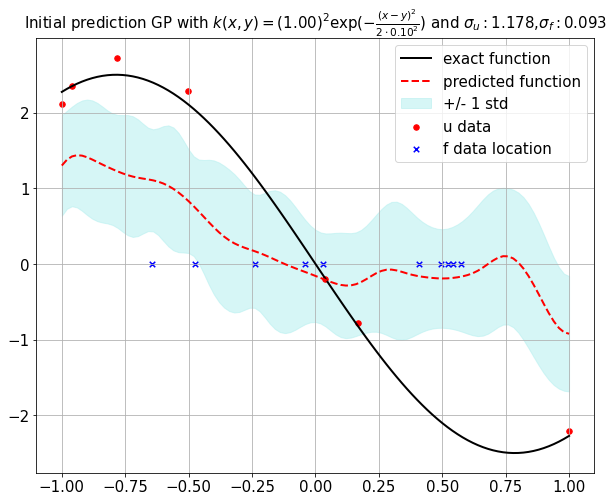

In [25]:
Mf = 10
Mb = 7
model = GP_1d(Mf = Mf,Mb = Mb,lengthscale=0.1,sigma=1,noise_level = 0.05,exact_func = None).to(device).double()


X = torch.linspace(-1,1,101,dtype = torch.float64).view(-1,1)
mean = model.predict_mean(X.to(device)).cpu()
variance = model.predict_variance(X.to(device)).cpu()
lb = mean - 1*torch.sqrt(variance)
ub = mean + 1*torch.sqrt(variance)
with torch.no_grad():
    plt.figure(figsize=(10,8),facecolor='white')
    plt.plot(X,model.exact_func(X),'k',linewidth = 2,label="exact function")
    
    plt.title(f"Initial prediction GP with $k(x,y)=({{{model.sigma.item():.2f}}})^2\\exp(-\\frac{{(x-y)^2}}{{2\\cdot{{{model.lengthscale.item():.2f}}}^2}})$ and $\\sigma_u:{{{model.sig_u.item():.3f}}}$,$\\sigma_f:{{{model.sig_f.item():.3f}}}$",fontsize=15)
    
    plt.plot(X,mean,'--r',label="predicted function",linewidth = 2)
    plt.fill_between(X.flatten(),lb.flatten(),ub.flatten(),alpha=0.5,label='+/- 1 std',color='paleturquoise')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.scatter(model.Xb.cpu().flatten(),model.Yb.cpu().flatten(),c='r',label="u data",s=30,marker='o')
    plt.scatter(model.Xf.cpu().flatten(),torch.zeros_like(model.Xf.cpu()).flatten(),c='b',label="f data location",s=30,marker='x')
    # plt.scatter(model.Xf.cpu().flatten(),model.Yf.cpu().flatten(),c='orange',label="fdata location",s=30,marker='v')
    plt.legend(fontsize=15)
    plt.grid()
    # plt.show()
    plt.savefig("poisson_1d_initial.png",bbox_inches='tight')

In [26]:
optimizer = torch.optim.LBFGS(model.parameters(),lr = 1,max_iter=1, history_size=100,line_search_fn ='strong_wolfe')
torch.autograd.set_detect_anomaly(True)

loss_LBFGS = []
total_start = time.time()
for _ in range(40000):
    start = time.time()
    
    
    def closure():
        
        # Zero gradients
        optimizer.zero_grad()
        loss = model.loss_func()
        # Backward pass
        loss.backward(retain_graph=False) # retain_graph=True
        
        return loss
    optimizer.step(closure)
    loss = closure()
    
    loss_LBFGS.append(loss.item())
    
    
    end = time.time()
    if _%50==0:
        print(f"Iter: {_}, Loss: {loss_LBFGS[_]} Training time: {end-start} seconds")
    
    if _>0 and loss_LBFGS[_]==loss_LBFGS[_-1]:
        break
total_end = time.time()
print(f"Total Time Cost:{total_end- total_start}")

Iter: 0, Loss: 12.27397661467673 Training time: 0.5922744274139404 seconds
Total Time Cost:23.734871864318848


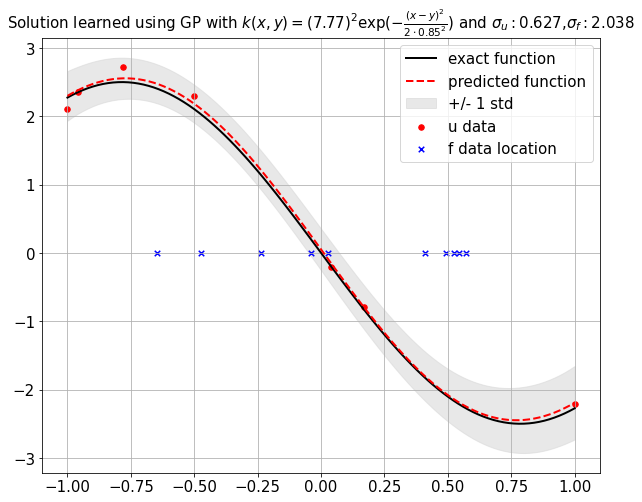

In [27]:
X = torch.linspace(-1,1,101,dtype = torch.float64).view(-1,1)
mean = model.predict_mean(X.to(device)).cpu()
variance = model.predict_variance(X.to(device)).cpu()
lb = mean - 1*torch.sqrt(variance)
ub = mean + 1*torch.sqrt(variance)
with torch.no_grad():
    plt.figure(figsize=(10,8),facecolor='white')
    plt.plot(X,model.exact_func(X),'k',linewidth = 2,label="exact function")
    
    plt.title(f"Solution learned using GP with $k(x,y)=({{{model.sigma.item():.2f}}})^2\\exp(-\\frac{{(x-y)^2}}{{2\\cdot{{{model.lengthscale.item():.2f}}}^2}})$ and $\\sigma_u:{{{model.sig_u.item():.3f}}}$,$\\sigma_f:{{{model.sig_f.item():.3f}}}$",fontsize=15)
    
    plt.plot(X,mean,'--r',label="predicted function",linewidth = 2)
    plt.fill_between(X.flatten(),lb.flatten(),ub.flatten(),alpha=0.5,label='+/- 1 std',color='lightgrey')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.scatter(model.Xb.cpu().flatten(),model.Yb.cpu().flatten(),c='r',label="u data",s=30,marker='o')
    plt.scatter(model.Xf.cpu().flatten(),torch.zeros_like(model.Xf.cpu()).flatten(),c='b',label="f data location",s=30,marker='x')
    # plt.scatter(model.Xf.cpu().flatten(),model.Yf.cpu().flatten(),c='orange',label="fdata",s=30,marker='v')

    plt.legend(fontsize=15,loc=1)
    plt.grid()
    # plt.show()
    plt.savefig("poisson_1d_learned.png",bbox_inches='tight')

In [6]:
def exact_func(x):
    return torch.cos(torch.pi*x)+x**2-x

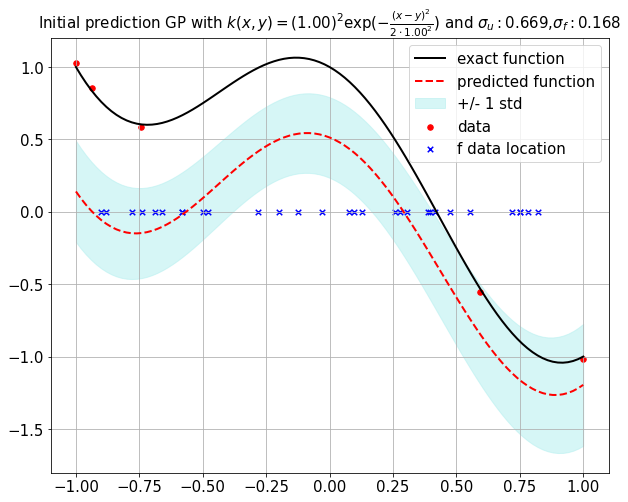

In [7]:
Mf = 30
Mb = 5
model = GP_1d(Mf = Mf,Mb = Mb,lengthscale=1,sigma=1,noise_level = 0.05,exact_func = exact_func).to(device).double()


X = torch.linspace(-1,1,101,dtype = torch.float64).view(-1,1)
mean = model.predict_mean(X.to(device)).cpu()
variance = model.predict_variance(X.to(device)).cpu()
lb = mean - 1*torch.sqrt(variance)
ub = mean + 1*torch.sqrt(variance)
with torch.no_grad():
    plt.figure(figsize=(10,8),facecolor='white')
    plt.plot(X,model.exact_func(X),'k',linewidth = 2,label="exact function")
    
    plt.title(f"Initial prediction GP with $k(x,y)=({{{model.sigma.item():.2f}}})^2\\exp(-\\frac{{(x-y)^2}}{{2\\cdot{{{model.lengthscale.item():.2f}}}^2}})$ and $\\sigma_u:{{{model.sig_u.item():.3f}}}$,$\\sigma_f:{{{model.sig_f.item():.3f}}}$",fontsize=15)
    
    plt.plot(X,mean,'--r',label="predicted function",linewidth = 2)
    plt.fill_between(X.flatten(),lb.flatten(),ub.flatten(),alpha=0.5,label='+/- 1 std',color='paleturquoise')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.scatter(model.Xb.cpu().flatten(),model.Yb.cpu().flatten(),c='r',label="data",s=30,marker='o')
    plt.scatter(model.Xf.cpu().flatten(),torch.zeros_like(model.Xf.cpu()).flatten(),c='b',label="f data location",s=30,marker='x')
    # plt.scatter(model.Xf.cpu().flatten(),model.Yf.cpu().flatten(),c='orange',label="fdata location",s=30,marker='v')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()
    # plt.savefig("regression_complex_func.png",bbox_inches='tight')

In [8]:
optimizer = torch.optim.LBFGS(model.parameters(),lr = 1,max_iter=1, history_size=100,line_search_fn ='strong_wolfe')
#torch.autograd.set_detect_anomaly(True)

loss_LBFGS = []
total_start = time.time()
for _ in range(40000):
    start = time.time()
    
    
    def closure():
        
        # Zero gradients
        optimizer.zero_grad()
        loss = model.loss_func()
        # Backward pass
        loss.backward(retain_graph=False) # retain_graph=True
        
        return loss
    optimizer.step(closure)
    loss = closure()
    
    loss_LBFGS.append(loss.item())
    
    
    end = time.time()
    if _%10==0:
        print(f"Iter: {_}, Loss: {loss_LBFGS[_]} Training time: {end-start} seconds")
    if _>0 and loss_LBFGS[_]==loss_LBFGS[_-1]:
        break
total_end = time.time()
print(f"Total Time Cost:{total_end- total_start}")

Iter: 0, Loss: 14.972554472400102 Training time: 0.3829386234283447 seconds
Iter: 10, Loss: 5.837205544816217 Training time: 0.3604907989501953 seconds
Iter: 20, Loss: 5.493760305876974 Training time: 0.3447697162628174 seconds
Iter: 30, Loss: 5.453704415065387 Training time: 0.35446643829345703 seconds
Total Time Cost:13.230491876602173


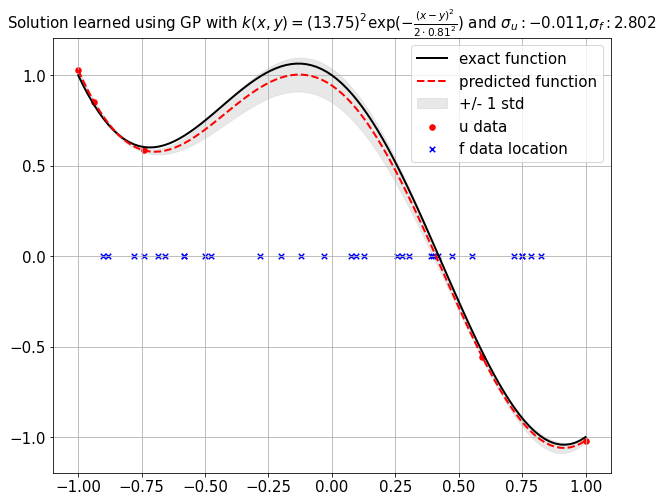

In [9]:
X = torch.linspace(-1,1,101,dtype = torch.float64).view(-1,1)
mean = model.predict_mean(X.to(device)).cpu()
variance = model.predict_variance(X.to(device)).cpu()
lb = mean - 1*torch.sqrt(variance)
ub = mean + 1*torch.sqrt(variance)
with torch.no_grad():
    plt.figure(figsize=(10,8),facecolor='white')
    plt.plot(X,model.exact_func(X),'k',linewidth = 2,label="exact function")
    
    plt.title(f"Solution learned using GP with $k(x,y)=({{{model.sigma.item():.2f}}})^2\\exp(-\\frac{{(x-y)^2}}{{2\\cdot{{{model.lengthscale.item():.2f}}}^2}})$ and $\\sigma_u:{{{model.sig_u.item():.3f}}}$,$\\sigma_f:{{{model.sig_f.item():.3f}}}$",fontsize=15)
    
    plt.plot(X,mean,'--r',label="predicted function",linewidth = 2)
    plt.fill_between(X.flatten(),lb.flatten(),ub.flatten(),alpha=0.5,label='+/- 1 std',color='lightgrey')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.scatter(model.Xb.cpu().flatten(),model.Yb.cpu().flatten(),c='r',label="u data",s=30,marker='o')
    plt.scatter(model.Xf.cpu().flatten(),torch.zeros_like(model.Xf.cpu()).flatten(),c='b',label="f data location",s=30,marker='x')
    # plt.scatter(model.Xf.cpu().flatten(),model.Yf.cpu().flatten(),c='orange',label="fdata",s=30,marker='v')

    plt.legend(fontsize=15,loc=1)
    plt.grid()
    # plt.show()
    plt.savefig("regression_complex_func.png",bbox_inches='tight')